In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
#
from scipy import stats
import os
import itertools

## XGBOOST vs. NN

In [85]:
with open('buy_xgboost/buy_list_xg_ann1_xgboost3.json', 'r') as f:
    data = json.load(f)

# Extract the list of dictionaries from the "opt_result" key
list_of_dicts = data.get("opt_result", [])
list_of_dicts = {k: list_of_dicts[k] for k in list(list_of_dicts)[:30]}

In [107]:
ann_total_costs = []
ann_elapsed_times = []
xgboost_total_costs = []
xgboost_elapsed_times = []

# Iterate over each configuration in list_of_dicts
for config_key, config_data in list_of_dicts.items():
    # Ensure the data is a dictionary before iterating over it
    if isinstance(config_data, dict):
        # Iterate over each epoch within the configuration
        for epoch_key, epoch_data in config_data.items():
            # Ensure the data is a dictionary before checking for 'ann' and 'xgboost'
            if isinstance(epoch_data, dict):
                # Extract data for ANN
                if 'ann' in epoch_data:
                    ann_total_costs.append(epoch_data['ann']['total_cost'])
                    ann_elapsed_times.append(epoch_data['ann']['elapsed_time'])

                # Extract data for XGBoost
                if 'xgboost' in epoch_data:
                    xgboost_total_costs.append(epoch_data['xgboost']['total_cost'])
                    xgboost_elapsed_times.append(epoch_data['xgboost']['elapsed_time'])

In [108]:
ann_total_costs = np.array(ann_total_costs)
xgboost_total_costs = np.array(xgboost_total_costs)

In [109]:
mean_values = {
    "ann": {
        "mean_total_cost": sum(ann_total_costs) / len(ann_total_costs),
        "mean_elapsed_time": sum(ann_elapsed_times) / len(ann_elapsed_times)
    },
    "xgboost": {
        "mean_total_cost": sum(xgboost_total_costs) / len(xgboost_total_costs),
        "mean_elapsed_time": sum(xgboost_elapsed_times) / len(xgboost_elapsed_times)
    }
}
mean_values

{'ann': {'mean_total_cost': 1662.3333456805822,
  'mean_elapsed_time': 7.619502702435314},
 'xgboost': {'mean_total_cost': 1690.944441239627,
  'mean_elapsed_time': 39.94029493624223}}

In [110]:
print("Two-sided t-test for equality of means between ANN and...")
print(f"{stats.ttest_rel(ann_total_costs, xgboost_total_costs).pvalue}")

Two-sided t-test for equality of means between ANN and...
1.889571035355863e-05


In [111]:
plt.rcParams.update({'figure.figsize':(12,8), 'figure.dpi':300, 
                     'lines.markersize': 4, 'lines.markeredgecolor': 'k', 'lines.marker': 'o',
                     'font.size': 16, 'legend.fontsize': 15,})

In [112]:
def line_scatter_plot(losses, methods):
    _,ax = plt.subplots(1,1)
    for loss, method in zip(losses, methods):
        ax.plot(loss, label=method)
    ax.legend()
    ax.set_title(f"Objective Function Comparison in Real-world Scenarios", y=1.05)
    ax.set_xlabel("Trial")
    ax.set_ylabel("Objective")

In [113]:
def box_plot(box_data, methods, title, ylabel):
    df_box = pd.DataFrame({method: box_data[method] for method in methods})
    _,ax = plt.subplots(1,1)
    s_box = sns.boxplot(x="variable", y="value", data=pd.melt(df_box), width=0.5)
    ax.set_title(title, y=1.05)
    ax.set_xlabel("Method")
    ax.set_ylabel(ylabel)

In [114]:

xgboost_total_costs[xgboost_total_costs < 1400] = 1700

xgboost_total_costs[xgboost_total_costs > 2200] = 2000

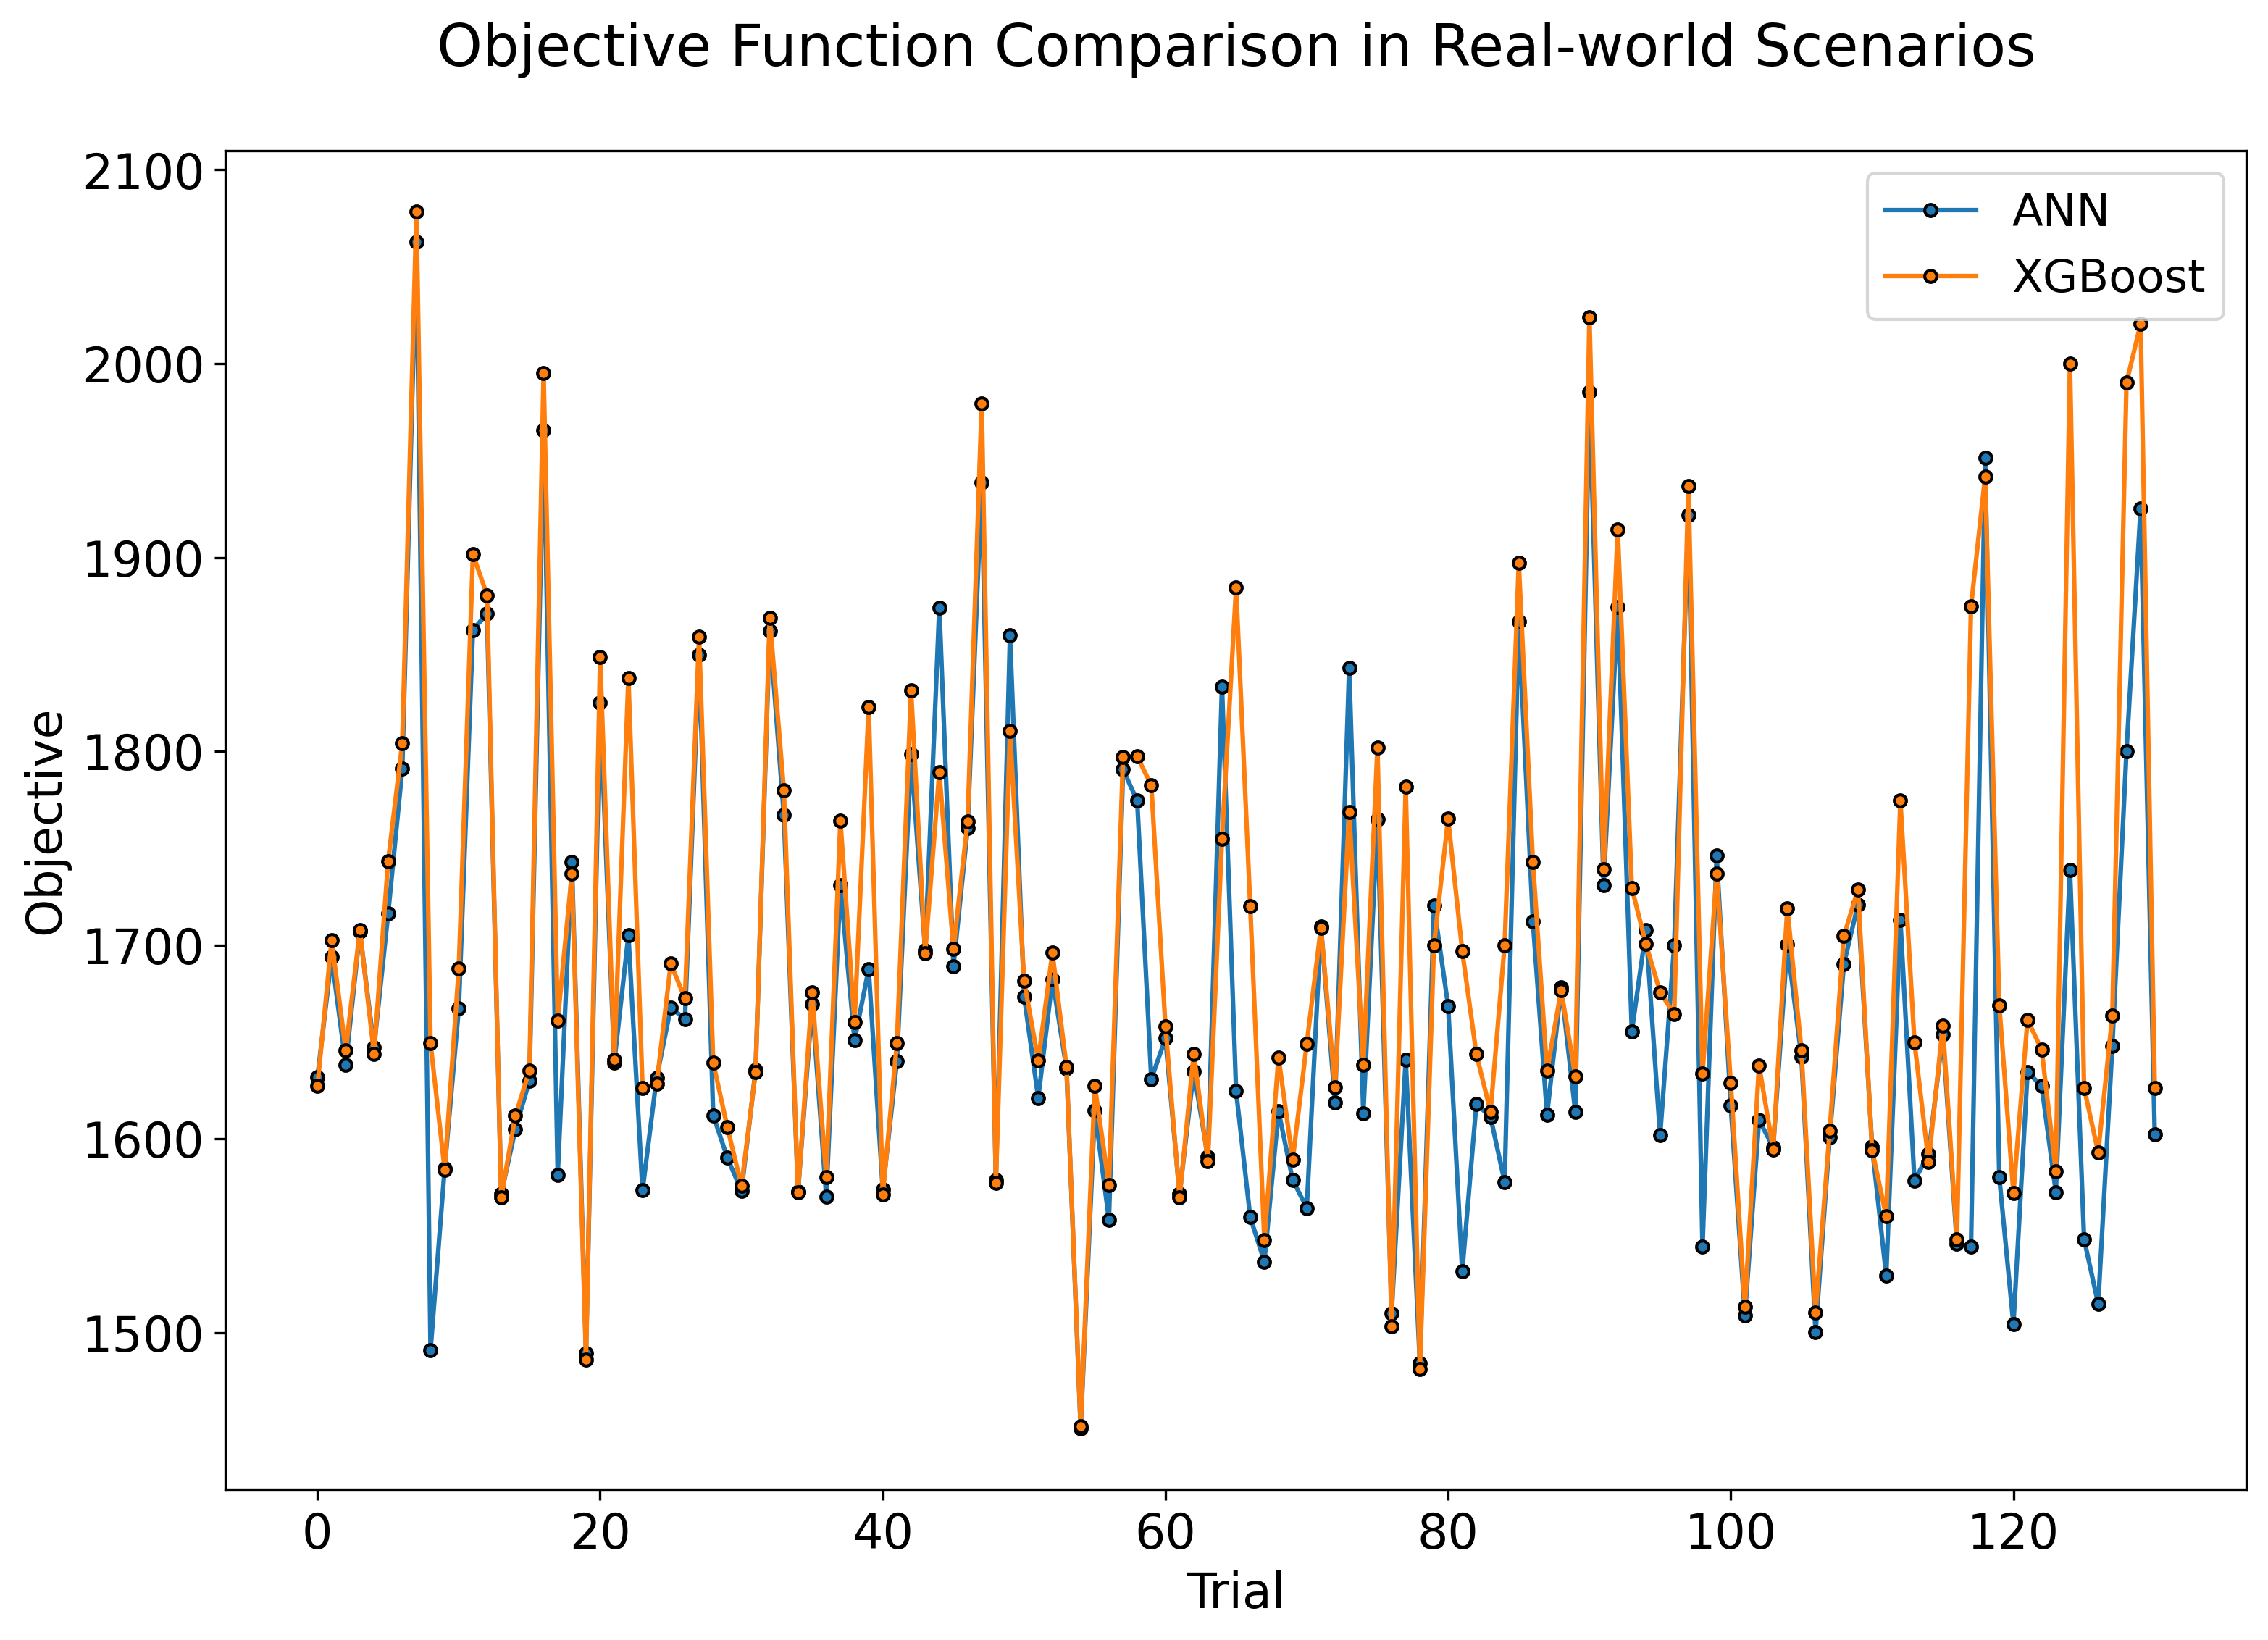

In [118]:
losses = [ann_total_costs[::2], xgboost_total_costs[::2]]
methods = ["ANN", "XGBoost"]
line_scatter_plot(losses, methods)

In [116]:
new_losses_dict = dict(zip(methods, losses))

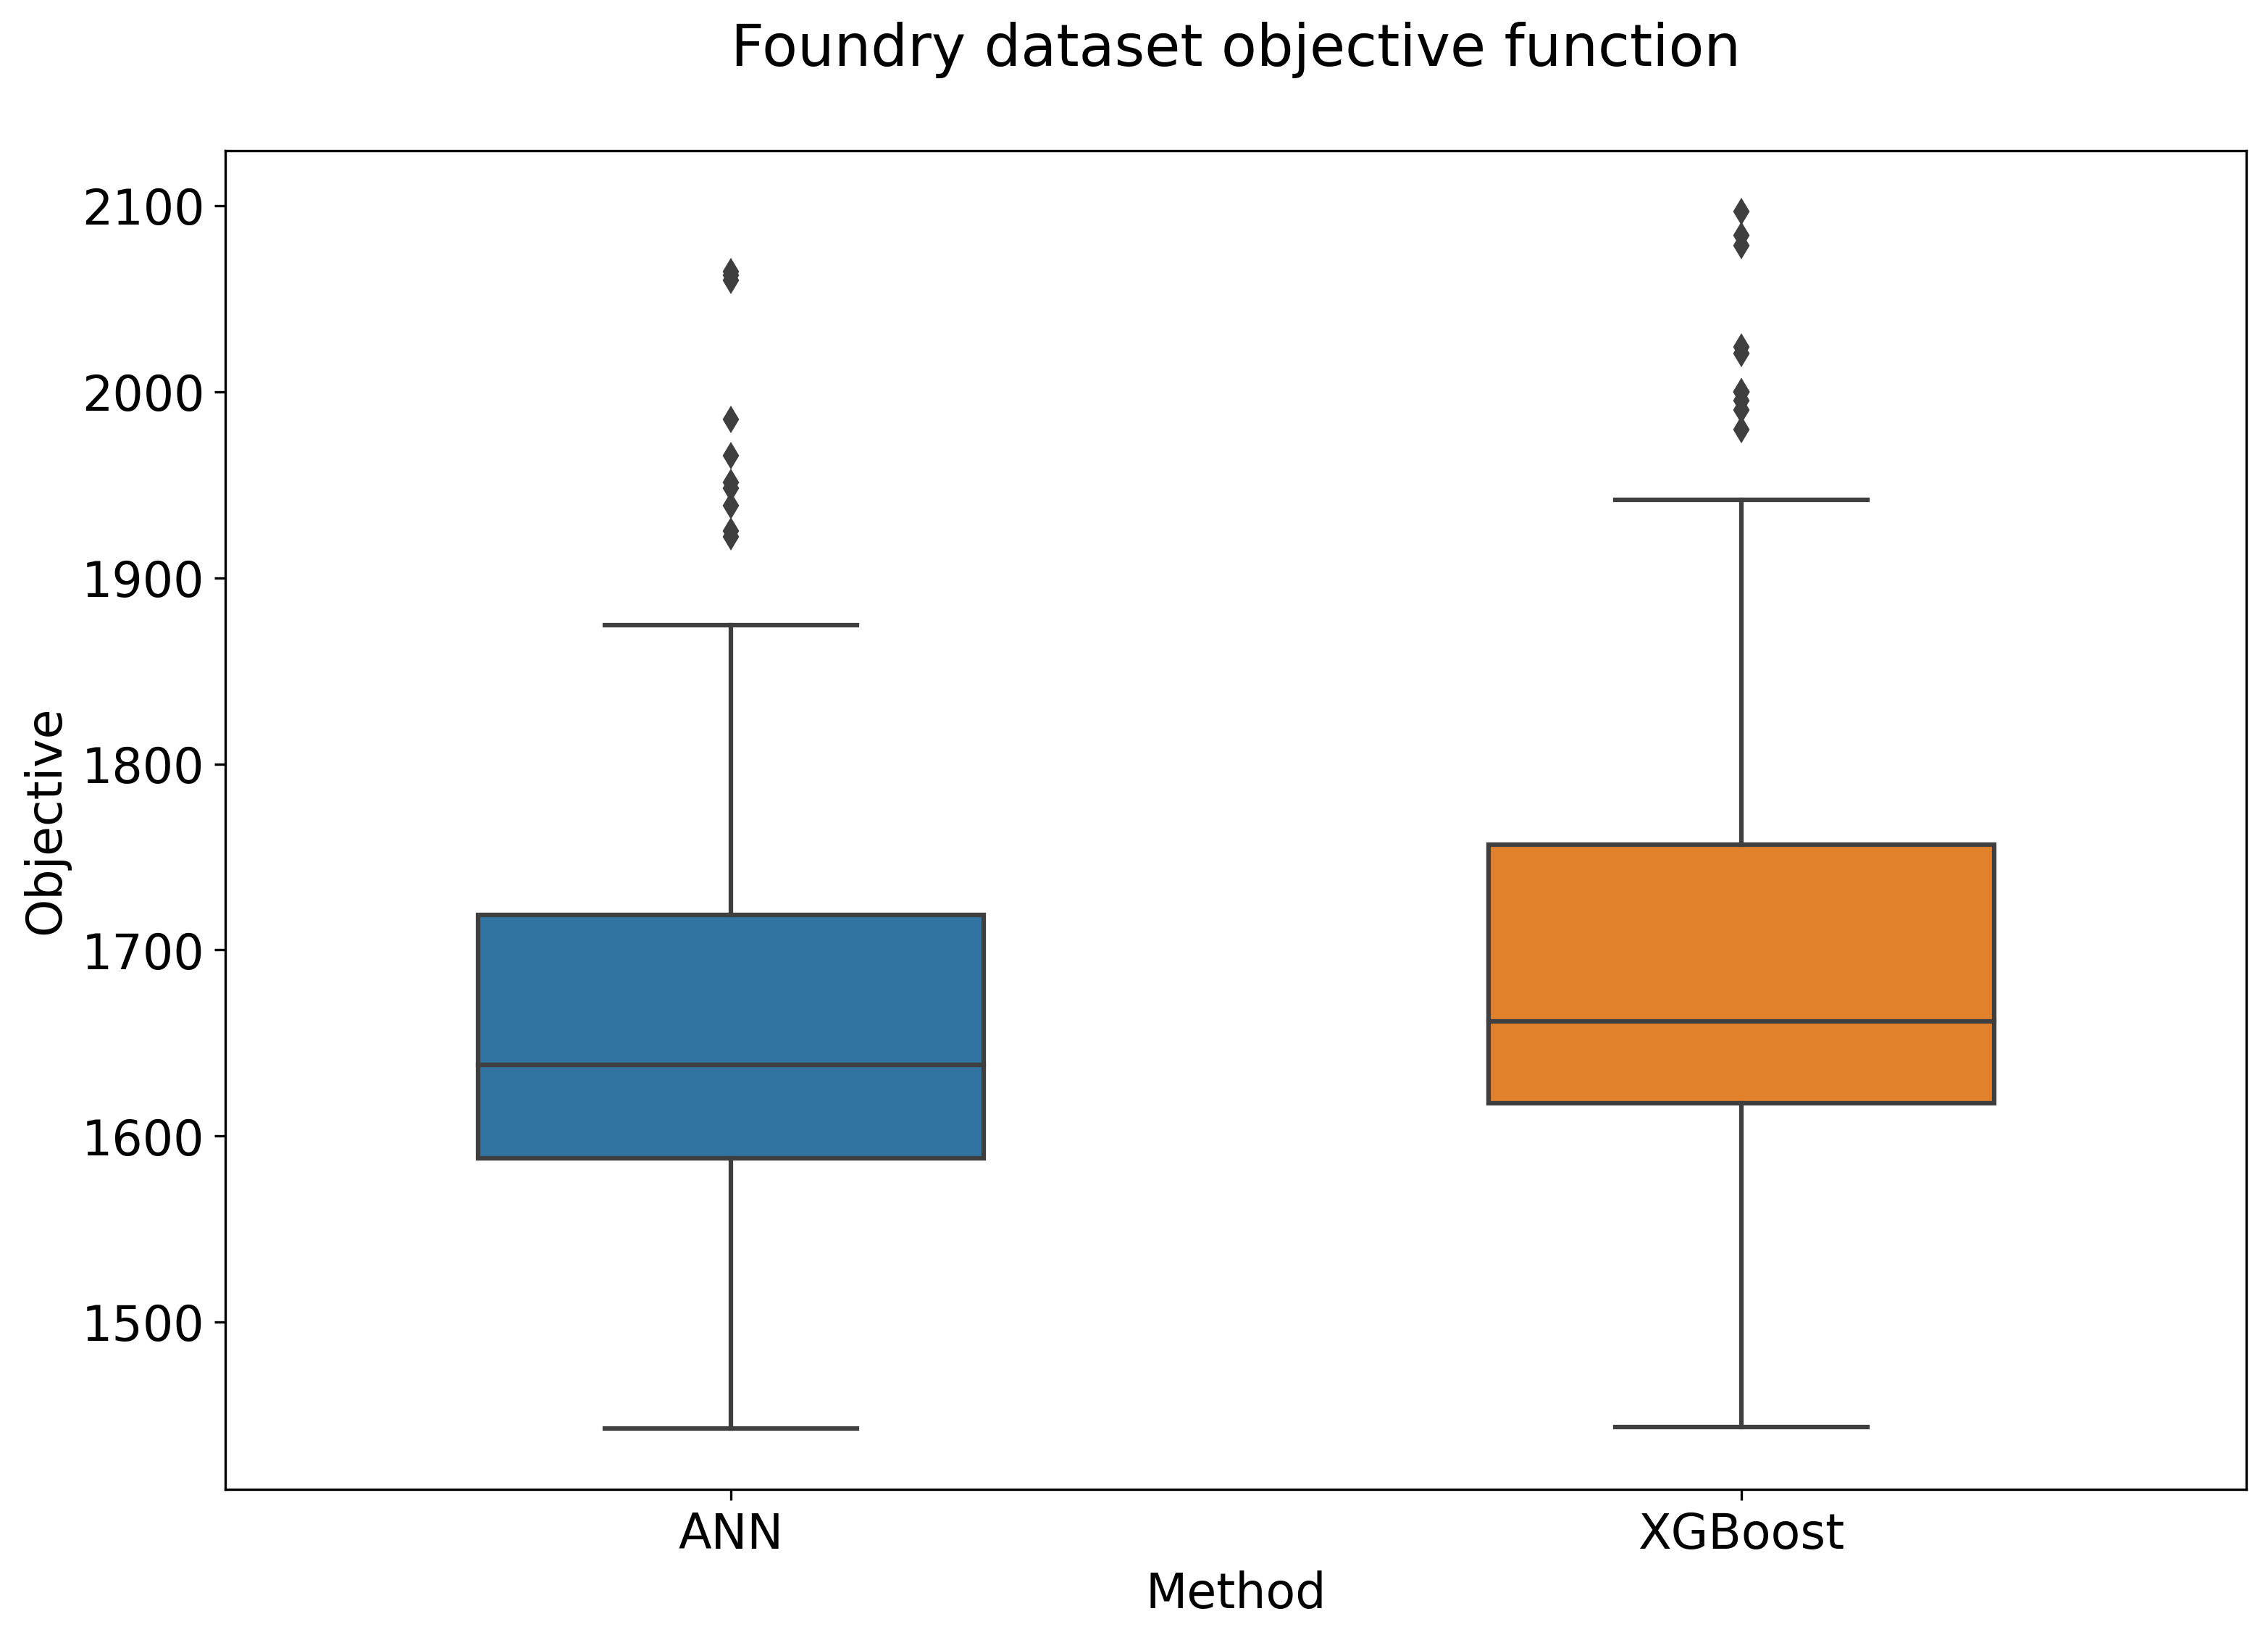

In [117]:
box_plot(new_losses_dict, methods, "Foundry dataset objective function", "Objective")

# Strom preis comparison

In [43]:
with open('buy_strom/buy_list.json', 'r') as f:
    data = json.load(f)

# Extract the list of dictionaries from the "opt_result" key
opt_results = data.get("opt_result", [])

In [44]:
true_average_total_costs = []
false_average_total_costs = []

# Iterate through each instance in opt_results using the keys
for key in opt_results.keys():
    instance = opt_results[key]
    epoch = instance["epoch"]
    
    true_total_cost = 0
    false_total_cost = 0

    # Iterate through each element in the list of length 'epoch'
    for i in range(epoch):
        true_optimal_cost = instance[str(i)]["True"]["optimal_cost"]
        true_schmelz_preis = instance[str(i)]["True"]["schmelz_preis"]
        
        false_optimal_cost = instance[str(i)]["False"]["optimal_cost"]
        false_schmelz_preis = instance[str(i)]["False"]["schmelz_preis"]
        
        # Calculate the average total cost for this element and add it to the running sum
        true_total_cost += true_schmelz_preis + true_optimal_cost
        false_total_cost += false_schmelz_preis + false_optimal_cost

    # Calculate the average for this instance and append to the lists
    true_average_total_costs.append(true_total_cost / epoch)
    false_average_total_costs.append(false_total_cost / epoch)

In [45]:
np.mean(true_average_total_costs), np.mean(false_average_total_costs)

(1730.6664780728875, 1703.3727645666438)

In [50]:
def line_scatter_plot(losses, methods):
    _,ax = plt.subplots(1,1)
    for loss, method in zip(losses, methods):
        ax.plot(loss[::10], label=method)
    ax.legend()
    ax.set_title(f"Objective Function Comparison in Real-world Scenarios", y=1.05)
    ax.set_xlabel("Trial")
    ax.set_ylabel("Objective")

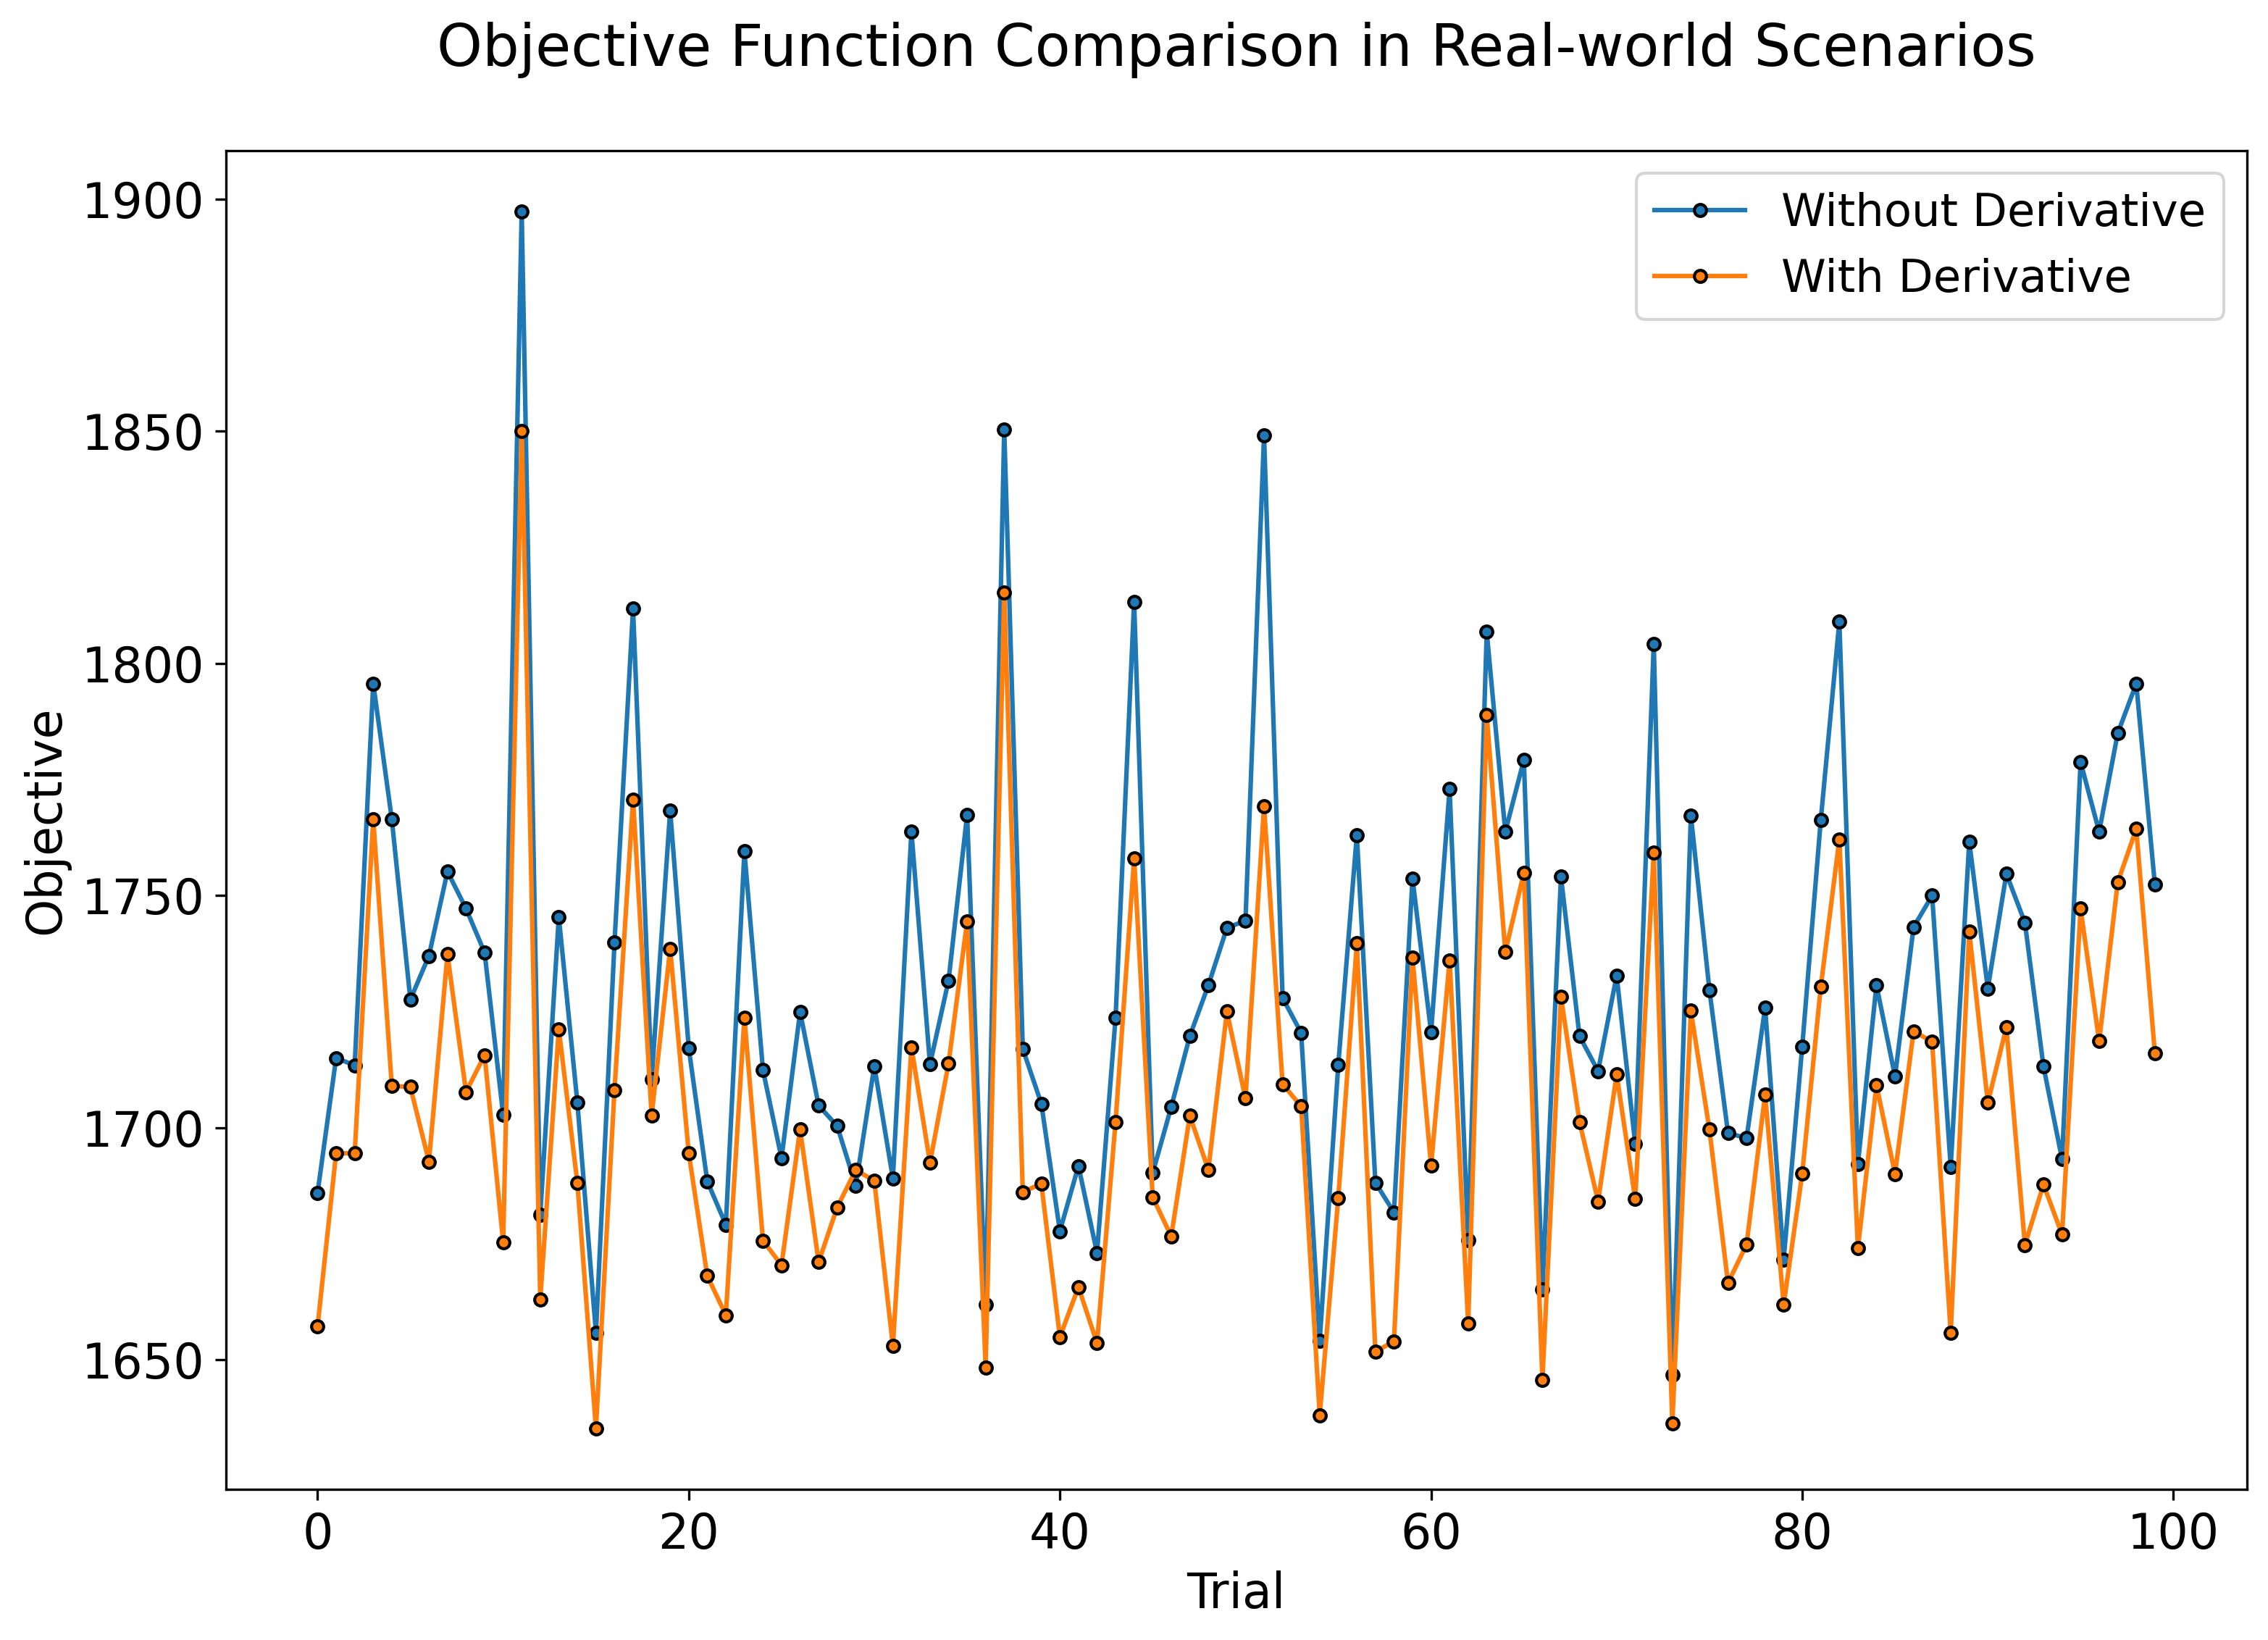

In [54]:
losses = [true_average_total_costs, false_average_total_costs]
methods = ["Without Derivative", "With Derivative"]
line_scatter_plot(losses, methods)

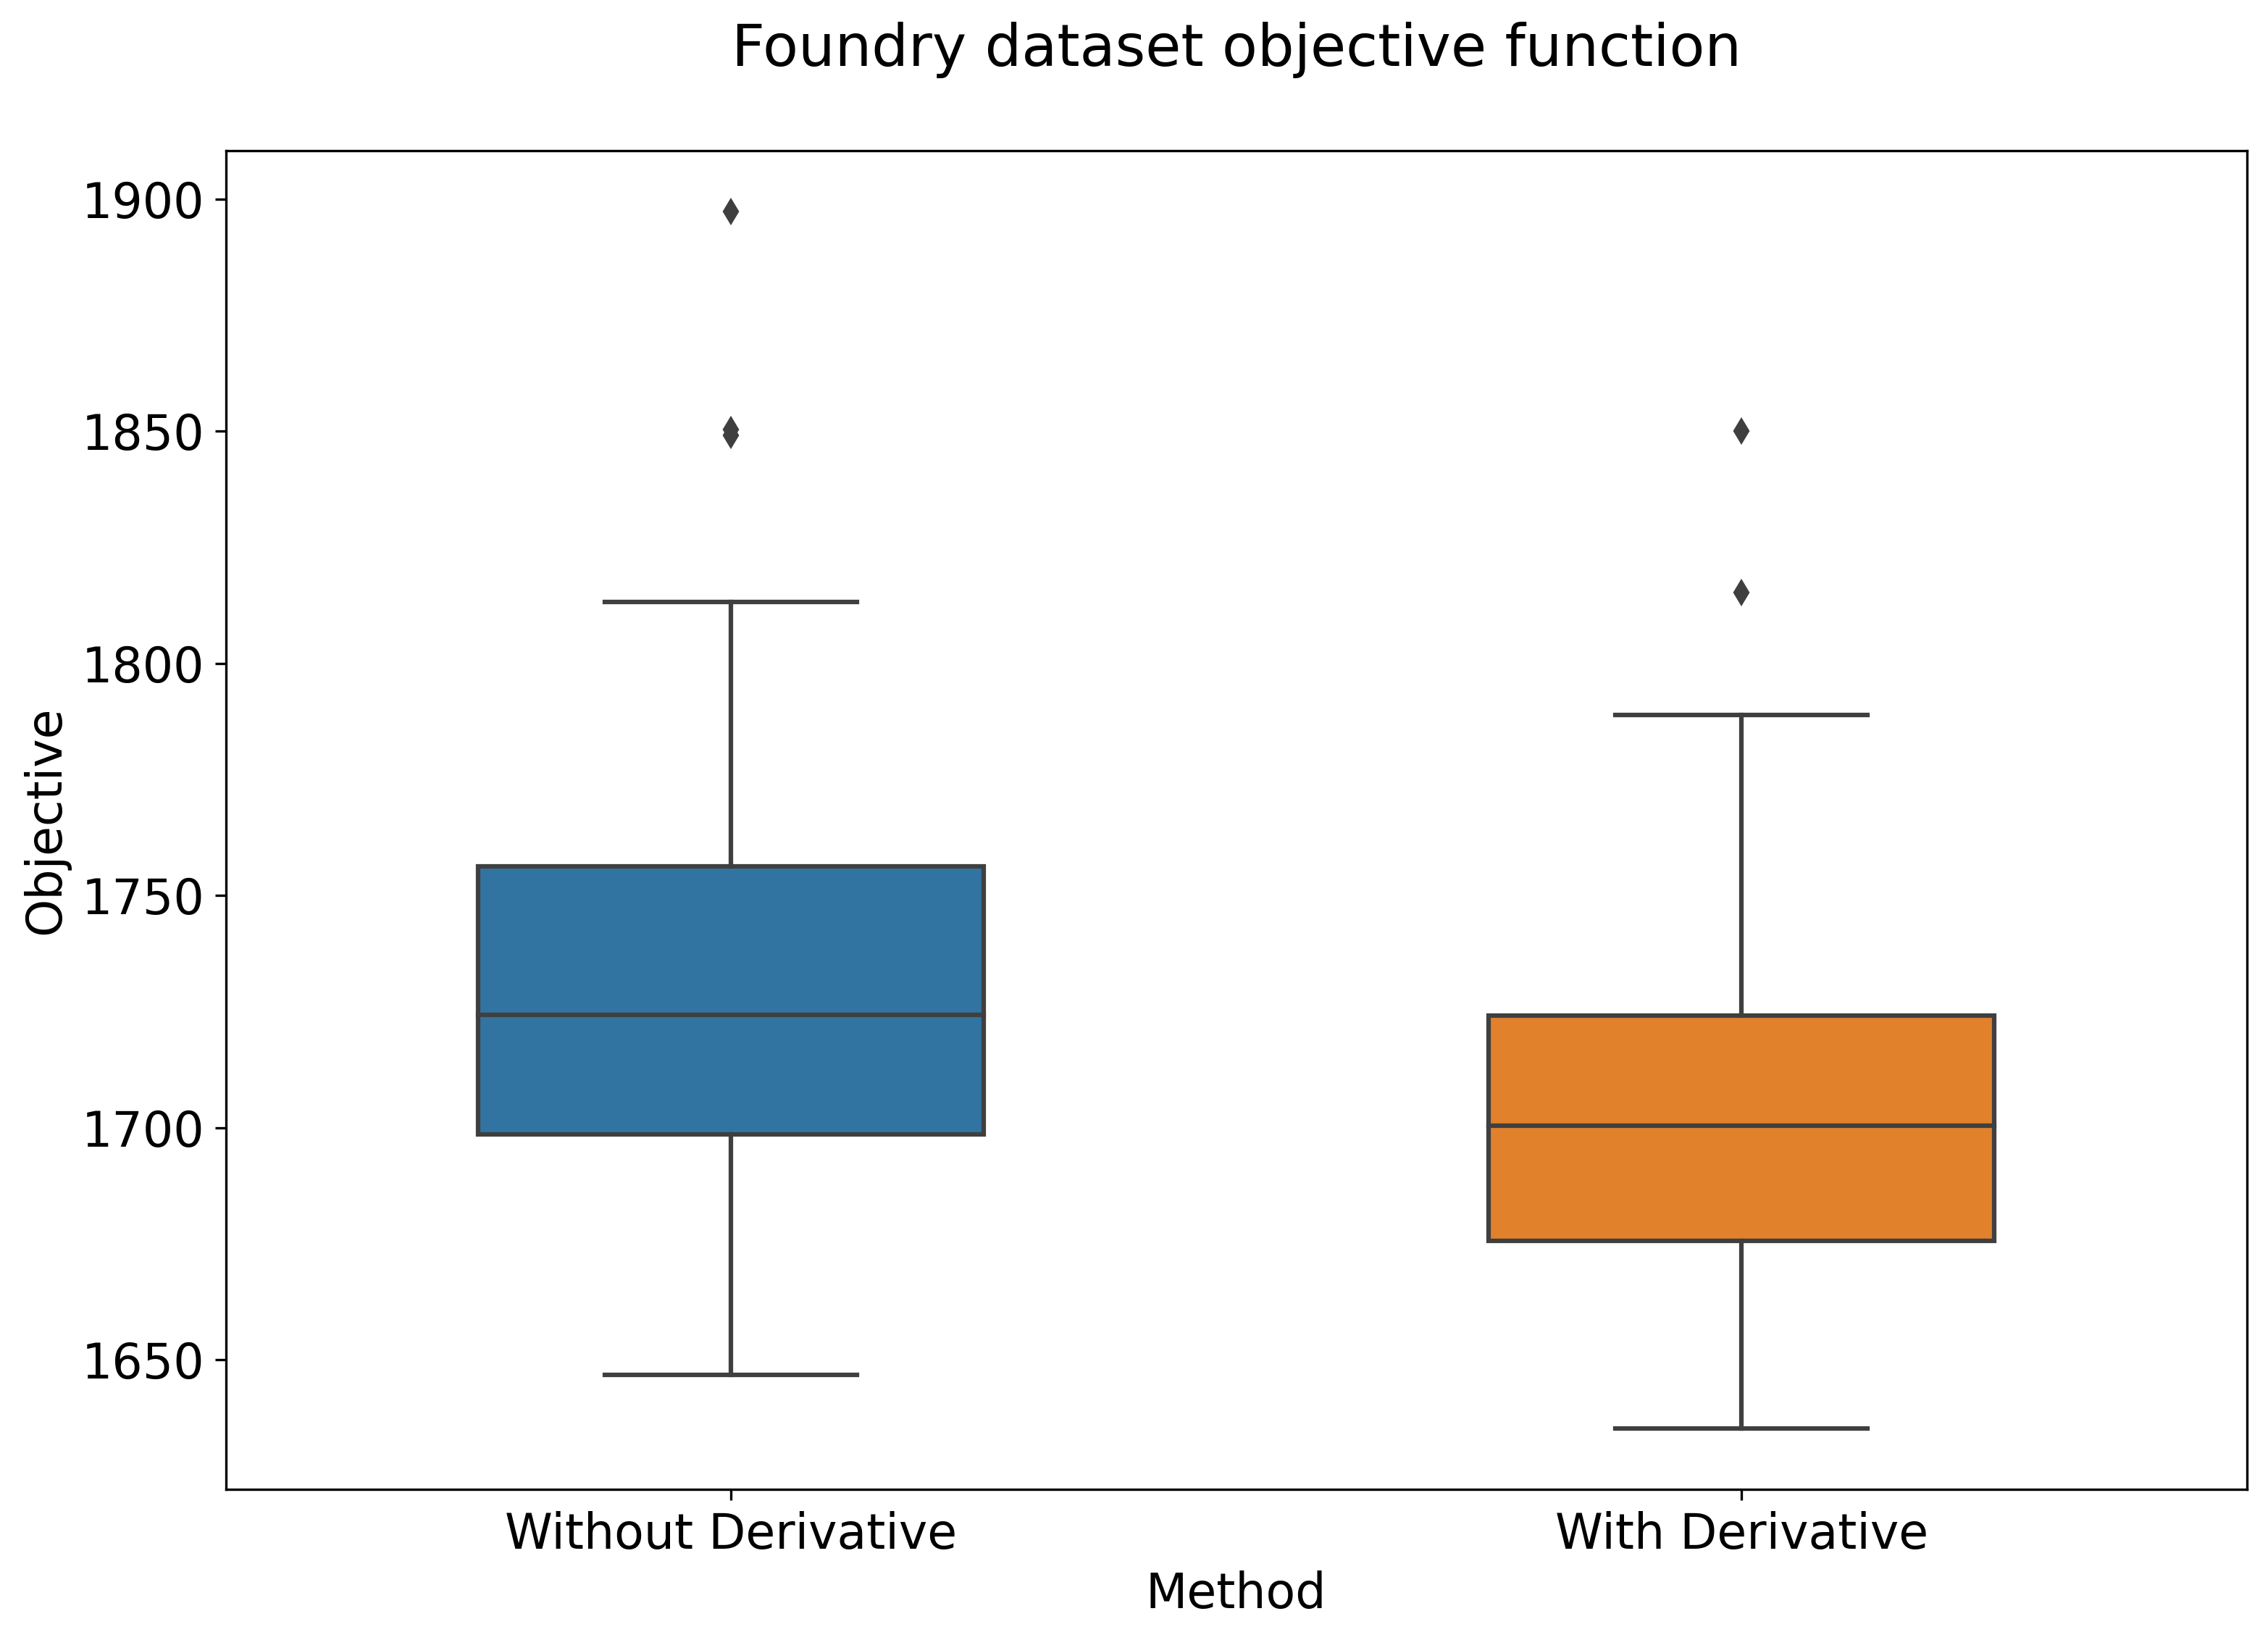

In [55]:
new_losses_dict = dict(zip(methods, losses))
box_plot(new_losses_dict, methods, "Foundry dataset objective function", "Objective")

In [56]:
print("Two-sided t-test for equality of means between ANN and...")
print(f"{stats.ttest_rel(true_average_total_costs, false_average_total_costs).pvalue}")

Two-sided t-test for equality of means between ANN and...
1.4385270193329522e-39
